<a href="https://colab.research.google.com/github/jigme42/CLS_Project_Darwin2025/blob/main/Ropper_River_Groundwater_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of moisture and vegetation changes in Roper River Basin**

## **Installing the key libraries**

In [ ]:
# Installing and importing geemap
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('geemap not found, installing via pip in Google Colab...')
        ! pip install geemap --quiet
        import geemap
    else:
        print('geemap not found, please install via conda in your environment')

In [ ]:
! pip install geopandas

###**Import libraries and authenticate Earth Engine**

In [ ]:
# Import the libraries
import geemap
import ee
import geopandas as gpd
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-roy')

EEException: Caller does not have required permission to use project ee-jigme. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=ee-jigme and then retry. Propagation of the new permission may take a few minutes.

###**Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/GEOPSY/

Mounted at /content/drive
ls: cannot access '/content/drive/MyDrive/GEOPSY/': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/Ropper_River/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ls: cannot access '/content/drive/Ropper_River/': No such file or directory


**Initializing Geemap**

In [ ]:
Map = geemap.Map(basemap='HYBRID')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **Reading the data**

In [ ]:
# Area of interest - the shapefile digitized on the GIS software
arboretum_shp = gpd.read_file("/content/drive/Ropper_River/aoi_extent.shp")
aoi = geemap.geopandas_to_ee(arboretum_shp)
Map.addLayer(aoi, {}, "Area of Interest")
Map.centerObject(aoi, 10); # Center shp and Zoom 17X
Map

NameError: name 'gpd' is not defined

## **Functions for Calculating Indices**

###**NDVI**

In [ ]:
# Normalized Difference Vegetation Index
def getNDVI(image):
    # Compute the NDVI using an expression.
    NDVI = image.expression('((NIR - RED) / (NIR + RED))', {
            'NIR': image.select ('B8'),
            'RED': image.select ('B4')
        }).rename("NDVI")

    image = image.addBands(NDVI)

    return(image)

##**Normalized Difference Water Index (NDWI)**

In [ ]:
# Modified Normalized Difference Water Index
def getMNDWI(image):
    # Compute the NDWI using an expression.
    MNDWI = image.expression('((GREEN - SWIR) / (GREEN + SWIR))', {
            'SWIR': image.select ('B11'),
            'GREEN': image.select ('B3')
        }).rename("MNDWI")

    image = image.addBands(MNDWI)

    return(image)

###**EVI**

In [ ]:
# Enhanced Vegetation Index
# EVI formula derived from (Jinru & Baofeng, 2017)'s
# Article title - Significant Remote Sensing Vegetation Indices: A Review of Developments and Applications
def getEVI(image):
    # Compute the EVI using an expression.
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8').divide(10000),
            'RED': image.select('B4').divide(10000),
            'BLUE': image.select('B2').divide(10000)
        }).rename("EVI")

    image = image.addBands(EVI)

    return(image)

###**LAI**

In [ ]:
# LAI - Leaf Area Index
# Cited from (Tri et al 2018)
# Article name - Selection of vegetation indices for mapping the sugarcane condition
# around the oil and gas field of North West Java Basin, Indonesia
def getLAI(image):
    LAI = image.expression(
        '(3.618*EVI - 0.118)', {
            'EVI': image.select('EVI')
        }).rename("LAI")

    image = image.addBands(LAI)

    return(image)

###**Date**

In [ ]:
# manage the date formating as per your requirements
# Mine is in format of YYYYMMdd
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

##**Image Collections**


**Function for masking clouds**

In [ ]:
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask)

In [ ]:
# Function for obtaining all the image collections while removing the redundancies
def process_s2_imagery(year, aoi):

  # Image collection for the specified year
  s2 = ee.ImageCollection('COPERNICUS/S2') \
      .filterDate(f'{year}-01-01', f'{year}-12-31').filterBounds(aoi) \
      .map(maskS2clouds).map(getNDVI).map(getMNDWI).map(getEVI).map(getLAI).map(addDate)

  # Calculate median value of the imagery collection
  s2_median = s2.median()

  return s2, s2_median


In [ ]:
# Applying our process_s2_imagery function to the different years.
# col_{year} represents the collection, while med_{year} represents the median image

# For 2015
col_15, med_15 = process_s2_imagery(2015, aoi)
# For 2016
col_16, med_16 = process_s2_imagery(2016, aoi)
# For 2017
col_17, med_17 = process_s2_imagery(2017, aoi)
# For 2018
col_18, med_18 = process_s2_imagery(2018, aoi)
# For 2019
col_19, med_19 = process_s2_imagery(2019, aoi)
# For 2020
col_20, med_20 = process_s2_imagery(2020, aoi)
# For 2021
col_21, med_21 = process_s2_imagery(2021, aoi)
# For 2022
col_22, med_22 = process_s2_imagery(2022, aoi)
# For 2023
col_23, med_23 = process_s2_imagery(2023, aoi)
#For 2024
col_24, med_24 = process_s2_imagery(2024, aoi)

In [ ]:
bands=med_17.bandNames()
bands

##**Visualization of Generated Indices**

###**Color Palettes**

In [ ]:
# Define the color palette for the NDVI, RGR, LAI and EVI layers
ndvi_colors = ['#FF0000', '#FFFF00', '#00FF00' ]  # green, yellow, red
evi_colors = [ 'brown', 'orange', 'yellow', 'green']  # blue, cyan, yellow, red
lai_colors = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
    '74A901', '66A000', '529400', '3E8601', '207401', '056201',
    '004C00', '023B01', '012E01', '011D01', '011301']
mndwi_colors = ['brown','white','blue' ]

In [ ]:
palette_ndvi = {"min":-0.2, "max":0.5, 'palette':ndvi_colors}
palette_evi = {"min":0.0, "max":0.5, 'palette':evi_colors}
palette_lai = {"min": 0.0, "max": 1.5, 'palette': lai_colors}
palette_mndwi = {"min":-0.5, "max":0.2, 'palette':mndwi_colors}

In [ ]:
# Function for visualizing the different indices for different years
def indices_visualization(index, years, aoi, palette):
  Map = geemap.Map(basemap='HYBRID')
  Map.centerObject(aoi, 11)

  for year in years:
    # Process Sentinel-2 imagery for the year
    s2, s2_median = process_s2_imagery(year, aoi)

    # Add layers to the map
    Map.addLayer(s2_median.clip(aoi).select(index), palette, f"{index}_{year}")

  Map.addLayerControl()

  # Add a color bar for the layer
  Map.add_colorbar(palette, label=index, layer_name=index, orientation="horizontal", transparent_bg=True)

  return Map

###**NDVI Maps**

Switch layers on and off by clicking the layers icon. Can also zoom in and out.

In [ ]:
# NDVI all years
index = "NDVI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Map = indices_visualization(index, years, aoi, palette_ndvi)
Map

Map(center=[-14.99176248805695, 133.2511005338981], controls=(WidgetControl(options=['position', 'transparent_…

###**EVI Maps**

In [ ]:
# EVI all years
index = "EVI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Map = indices_visualization(index, years, aoi, palette_evi)
Map

Map(center=[-14.99176248805695, 133.2511005338981], controls=(WidgetControl(options=['position', 'transparent_…

###**LAI Maps**

In [ ]:
# LAI all years
index = "LAI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Map = indices_visualization(index, years, aoi, palette_lai)
Map

Map(center=[-14.99176248805695, 133.2511005338981], controls=(WidgetControl(options=['position', 'transparent_…

###**MNDWI Maps**

In [ ]:
# RGR all years
index = "MNDWI"
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Map = indices_visualization(index, years, aoi, palette_mndwi)
Map

Map(center=[-14.99176248805695, 133.2511005338981], controls=(WidgetControl(options=['position', 'transparent_…

Plotting the indices

In [ ]:
# function for calculating all the indices
def calculate_all_indices(image):
  image=getEVI(image)
  image=getLAI(image)
  image=getMNDWI(image)
  image=getNDVI(image)

  return image

In [ ]:
year = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
def process_sentinel_images(roi, start_year, end_year):
    processed_images = {}
    for year in range(start_year, end_year + 1):
        sentinel_collection = ee.ImageCollection('COPERNICUS/S2') \
                              .filterDate(f'{year}-01-01', f'{year}-12-31') \
                              .filterBounds(aoi) \
                              .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12'])
        sentinel_median = sentinel_collection.median()
        sentinel_with_indices = calculate_all_indices(sentinel_median)
        processed_images[year] = sentinel_with_indices.set('year', year)
    return processed_images




In [ ]:
sentinel_images=process_sentinel_images(aoi, 2015, 2024)
sentinel_images

{2015: <ee.image.Image at 0x79b83b52ebf0>,
 2016: <ee.image.Image at 0x79b83b52f1f0>,
 2017: <ee.image.Image at 0x79b83b5dfee0>,
 2018: <ee.image.Image at 0x79b83aa6f610>,
 2019: <ee.image.Image at 0x79b83aa6fc10>,
 2020: <ee.image.Image at 0x79b83aa6e080>,
 2021: <ee.image.Image at 0x79b83a8a3610>,
 2022: <ee.image.Image at 0x79b83a8aab30>,
 2023: <ee.image.Image at 0x79b83a8ab130>,
 2024: <ee.image.Image at 0x79b83a8b6530>}

In [ ]:
print(sentinel_images)

{2015: <ee.image.Image object at 0x79b84506a470>, 2016: <ee.image.Image object at 0x79b84523fac0>, 2017: <ee.image.Image object at 0x79b845583790>, 2018: <ee.image.Image object at 0x79b8453341c0>, 2019: <ee.image.Image object at 0x79b844c9efe0>, 2020: <ee.image.Image object at 0x79b877f89570>, 2021: <ee.image.Image object at 0x79b877f8b7c0>, 2022: <ee.image.Image object at 0x79b8452522f0>, 2023: <ee.image.Image object at 0x79b845252170>, 2024: <ee.image.Image object at 0x79b877ec4910>}


In [ ]:
img_2015=sentinel_images[2015]
img_2015

In [ ]:
ndvi_values={year:sentinel_images[year].select('NDVI').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30
).getInfo().get('NDVI')for year in years}

In [ ]:
evi_values={year:sentinel_images[year].select('EVI').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30
).getInfo().get('EVI') for year in years}

In [ ]:
mndwi_values={year:sentinel_images[year].select('MNDWI').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30
).getInfo().get('MNDWI')for year in years}

In [ ]:
lai_values={year:sentinel_images[year].select('LAI').reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30
).getInfo().get('LAI')for year in years}

In [ ]:
# converting the values into a dataframe
indices_df=pd.DataFrame({
    'Year':years,
    'NDVI':[ndvi_values[year]for year in years],
    'EVI': [evi_values[year]for year in years],
    'MNDWI':[mndwi_values[year]for year in years],
    'LAI':[lai_values[year] for year in years]
})

In [ ]:
indices_df.head()

,Year,NDVI,EVI,MNDWI,LAI
0,2015,0.262728,0.197879,-0.425130,0.597924
1,2016,0.278571,0.211849,-0.444358,0.648471
2,2017,0.285691,0.217823,-0.420466,0.670082
3,2018,0.293745,0.227210,-0.397064,0.704046
4,2019,0.253017,0.192799,-0.398513,0.579548


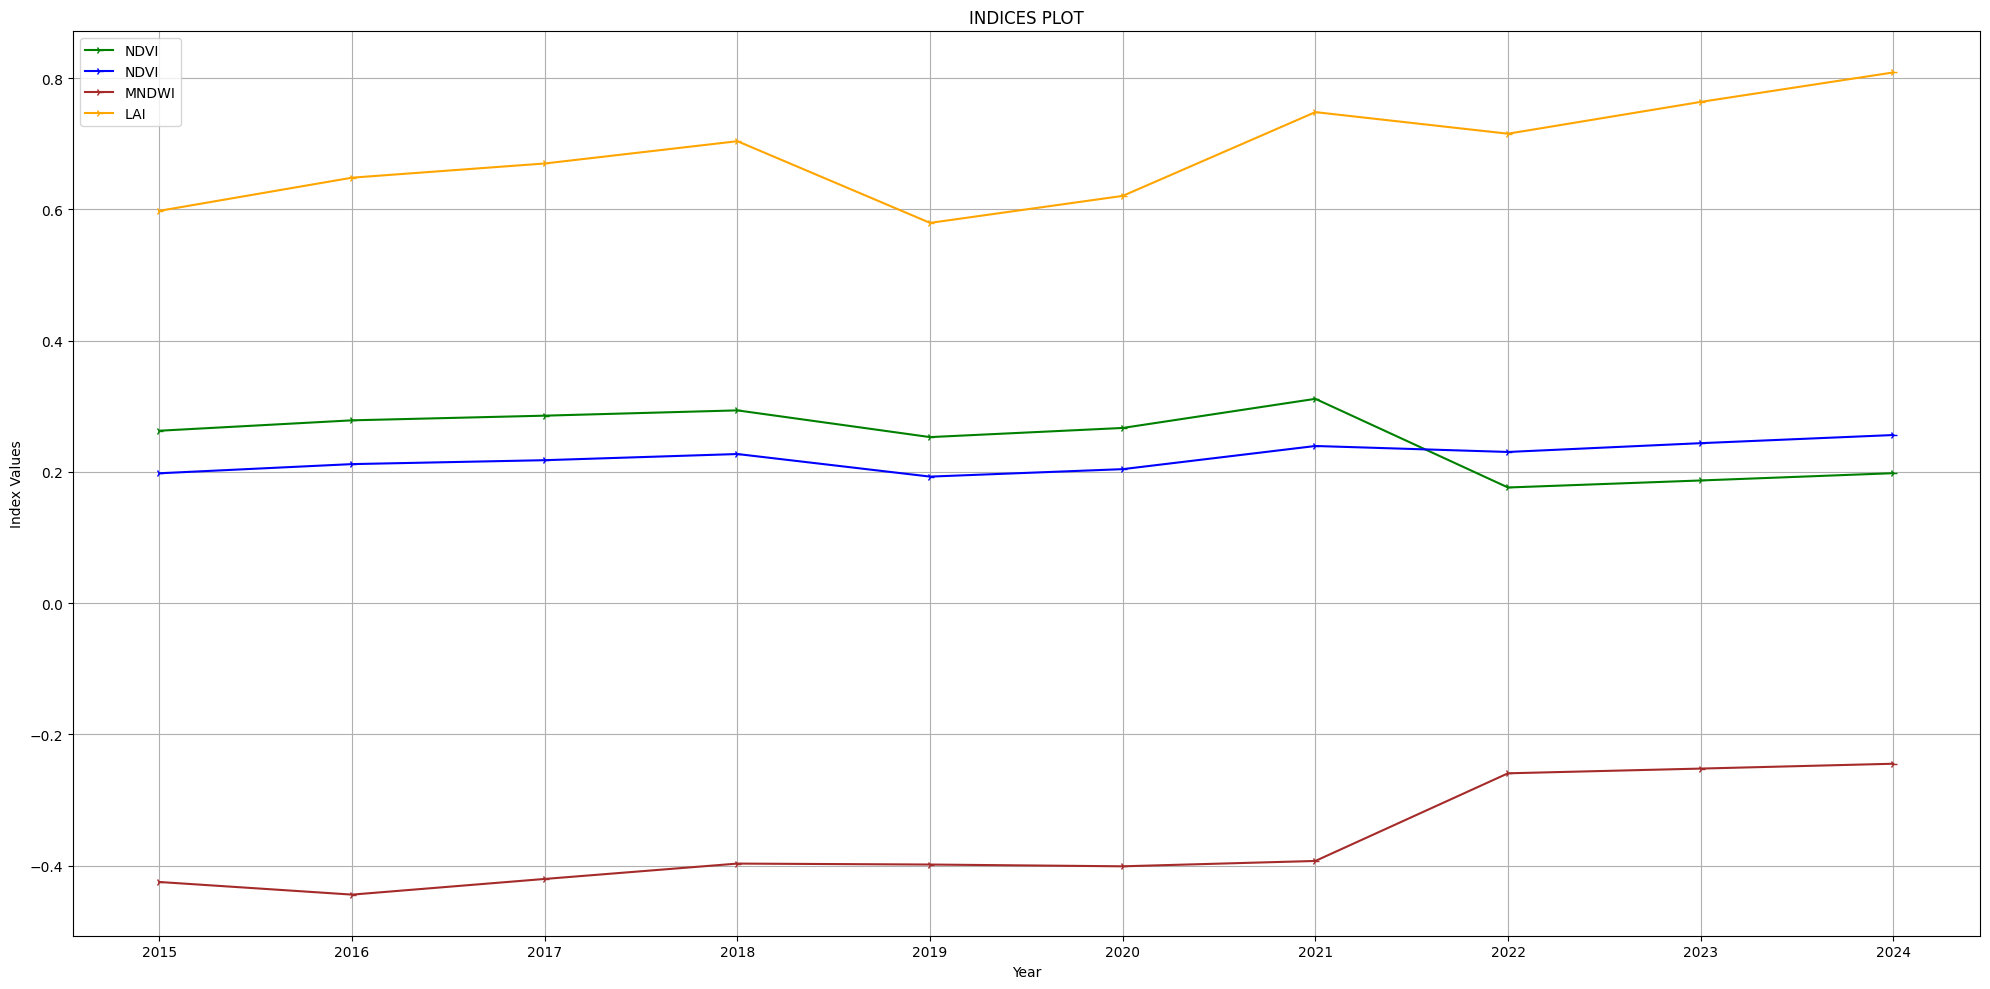

In [ ]:
# Plotting a line graph of the indices
plt.figure(figsize=(20,10))
plt.plot(indices_df['Year'],indices_df['NDVI'], label='NDVI', marker='4',linestyle='-', color='green')
plt.plot(indices_df['Year'], indices_df['EVI'], label='NDVI', marker='4',linestyle='-', color='blue')
plt.plot(indices_df['Year'], indices_df['MNDWI'], label='MNDWI', marker='4',linestyle='-', color='brown')
plt.plot(indices_df['Year'], indices_df['LAI'], label='LAI', marker='4',linestyle='-', color='orange' )

plt.title('INDICES PLOT')
plt.xlabel('Year')
plt.ylabel('Index Values')
plt.legend()
plt.grid(True)
plt.xticks(years)
plt.tight_layout()
plt.show()

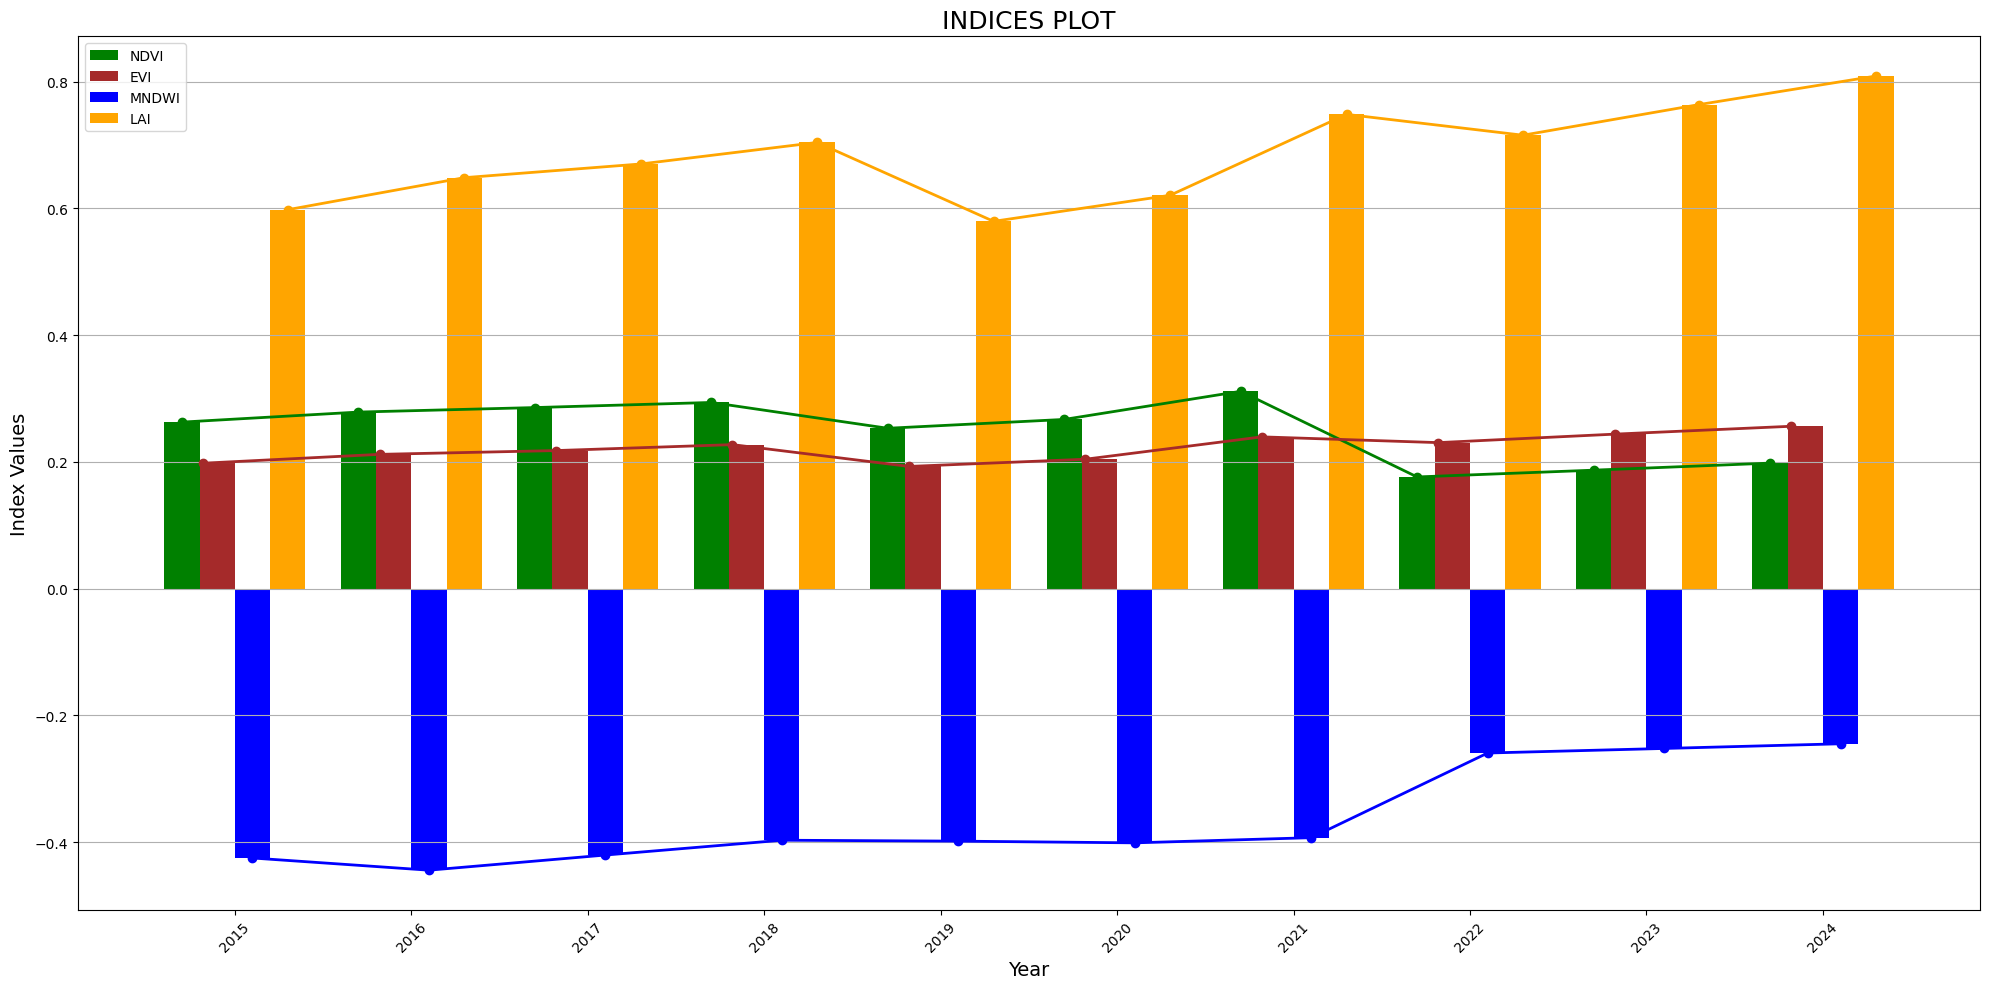

In [ ]:
#plotting a bar graph of the indices
index=np.arange(len(indices_df['Year']))
bar_width=0.2
plt.figure(figsize=(20, 10))
plt.bar(index, indices_df['NDVI'], width=bar_width, label='NDVI', color='green', align='center')
plt.bar(index + bar_width, indices_df['EVI'], width=bar_width, label='EVI', color='brown', align='center')
plt.bar(index + 2 * bar_width, indices_df['MNDWI'], width=bar_width, label='MNDWI', color='blue', align='center')
plt.bar(index + 3 * bar_width, indices_df['LAI'], width=bar_width, label='LAI', color='orange', align='center')


plt.plot(index, indices_df['NDVI'], marker='o', linestyle='-', color='green', linewidth=2)
plt.plot(index + 3 *  bar_width * bar_width, indices_df['EVI'], marker='o', linestyle='-', color='brown', linewidth=2)
plt.plot(index + 2 * bar_width, indices_df['MNDWI'], marker='o', linestyle='-', color='blue', linewidth=2)
plt.plot(index + 3 * bar_width, indices_df['LAI'], marker='o', linestyle='-', color='orange', linewidth=2)

# plt.title('INDICES PLOT')
# plt.xlabel('Year')
# plt.ylabel('Index Values')
# plt.legend()
# plt.grid(True)
# plt.xticks(years)
# plt.tight_layout()
# plt.show()
figsize=(20, 10)
peak_values=indices_df[['EVI', 'NDVI', 'MNDWI', 'LAI']]
plt.title('INDICES PLOT', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Index Values', fontsize=14)
plt.xticks(index + 1.5 * bar_width, indices_df['Year'], rotation=45)
plt.legend()
plt.grid(True, axis= 'y')
plt.tight_layout()

plt.show()

   Year      NDVI
0  2015  0.262728
1  2016  0.278571
2  2017  0.285691
3  2018  0.293745
4  2019  0.253017
5  2020  0.266957
6  2021  0.311340
7  2022  0.176204
8  2023  0.186902
9  2024  0.198026


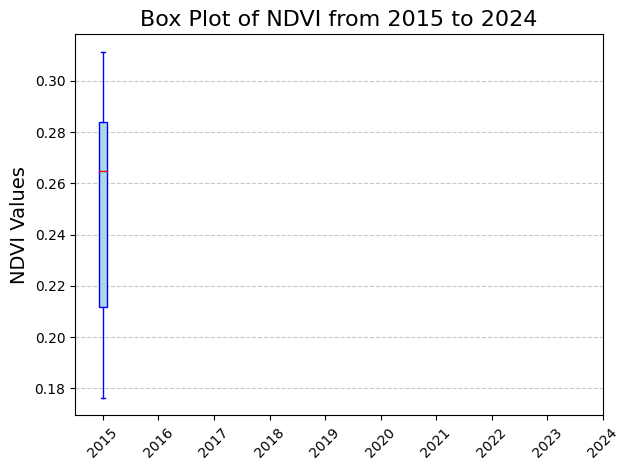

In [ ]:
# Creating  a bos=x plot of NDVI of range 2015 to 2024
ndvi_df=indices_df[['Year', 'NDVI']]
print(ndvi_df)
figsize=(20, 10)
plt.boxplot(ndvi_df['NDVI'], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'))
plt.title('Box Plot of NDVI from 2015 to 2024', fontsize=16)
plt.ylabel('NDVI Values', fontsize=14)
plt.xticks(ticks=np.arange(1, len(ndvi_df['Year'])+1), labels=ndvi_df['Year'], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

###**Function for exporting the Indices**

In [ ]:
def indices_export(indices, years, aoi):# Rename
    # Create the map
    Map = geemap.Map()
    Map.centerObject(aoi, 17)

    # Initialize empty lists to store the images for each index
    index_images = {index: [] for index in indices}
    palettes = {'NDVI': palette_ndvi, 'EVI': palette_evi, 'LAI': palette_lai, 'MNDWI': palette_mndwi}

    # Process Sentinel-2 imagery for each year
    for year in years:
        # Process Sentinel-2 imagery for the year
        s2, s2_median = process_s2_imagery(year, aoi)

        # Add layers to the map and append the images to their respective lists
        for index in indices:
            Map.addLayer(s2_median.clip(aoi).select(index), palettes[index], f"{index}_{year}")
            index_images[index].append(s2_median.clip(aoi).select(index))

    Map.addLayerControl()

    # Add a color bar for each index layer
    for index in indices:
        Map.add_colorbar(palettes[index], label=index, layer_name=index, orientation="horizontal", transparent_bg=True)

    return Map, index_images


In [ ]:
# We call the function
indices = ['NDVI', 'EVI', 'LAI', 'MNDWI']
Map, index_images = indices_export(indices, years, aoi)


In [ ]:
# We export the images. We need to iterate over the indices and their respective images
for index in indices:
    for i, year in enumerate(years):
        img = index_images[index][i]
        bounds_fc = aoi.map(lambda f: ee.Feature(f.geometry().bounds()))
        bounds = bounds_fc.geometry().getInfo()['coordinates'][0]
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f"{index}_{year}",
            fileNamePrefix=f"{index}_{year}",
            folder='/content/drive/MyDrive/GEOPSY/', # Folder that will be created in the drive for saving these images
            scale=30,
            region=bounds
        )
        task.start()


In [ ]:
task.status()

{'state': 'READY',
 'description': 'MNDWI_2024',
 'priority': 100,
 'creation_timestamp_ms': 1729596758124,
 'update_timestamp_ms': 1729596758124,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'A5LOJVKKMYZFPGKSL6PXD5ZK',
 'name': 'projects/ee-royspencerkipchirchir/operations/A5LOJVKKMYZFPGKSL6PXD5ZK'}